In [1]:
from qdrant_client import QdrantClient
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore

from langchain_ollama.llms import OllamaLLM
from langchain import hub
from tqdm import tqdm

from graph_run.nodes import (
    retrieve, grade_documents, generate, transform_query, prepare_for_final_grade
)
from graph_run.edges import (
    decide_to_generate, grade_generation_vs_documents, grade_generation_vs_question
)
from graph_run.state import GraphState

C:\Users\ivann\AppData\Local\Temp\ipykernel_13832\88980997.py:9: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from graph_run.nodes import (


### Подключение к Qdrant

In [2]:
client = QdrantClient(path="../data/langchain_qdrant_10percent")
embedder = HuggingFaceEmbeddings(model_name="sergeyzh/rubert-tiny-turbo")
collection_name = "embed_collection_10percent"

vector_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embedder
)
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k":5})

C:\Users\ivann\AppData\Local\Temp\ipykernel_13832\1559814182.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(model_name="sergeyzh/rubert-tiny-turbo")
d:\Vscode_projects\Intro_to_LLM\habr_rag_bot\.habr_rag_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "herenickname/t-tech_T-lite-it-1.0:q4_k_m"
llm = OllamaLLM(model=model_name, base_url= "http://localhost:11434")

## LangGraph RAG

In [5]:
import pprint
from functools import partial

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
retrieve_with_retriever = partial(retrieve, retriever=retriever)
workflow.add_node("retrieve", retrieve_with_retriever)  # retrieve

grade_documents_with_llm = partial(grade_documents, llm=llm)
workflow.add_node("grade_documents", grade_documents_with_llm)  # grade documents

generate_with_llm = partial(generate, llm=llm)
workflow.add_node("generate", generate_with_llm)  # generatae

transform_query_with_llm = partial(transform_query, llm=llm)
workflow.add_node("transform_query", transform_query_with_llm)  # transform_query

workflow.add_node("prepare_for_final_grade", prepare_for_final_grade)  # passthrough

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")

grade_generation_vs_documents_with_llm = partial(grade_generation_vs_documents, llm=llm)
workflow.add_conditional_edges(
    "generate",
    grade_generation_vs_documents_with_llm,
    {
        "supported": "prepare_for_final_grade",
        "not supported": "generate",
    },
)

grade_generation_vs_question_with_llm = partial(grade_generation_vs_question, llm=llm)

workflow.add_conditional_edges(
    "prepare_for_final_grade",
    grade_generation_vs_question_with_llm,
    {
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

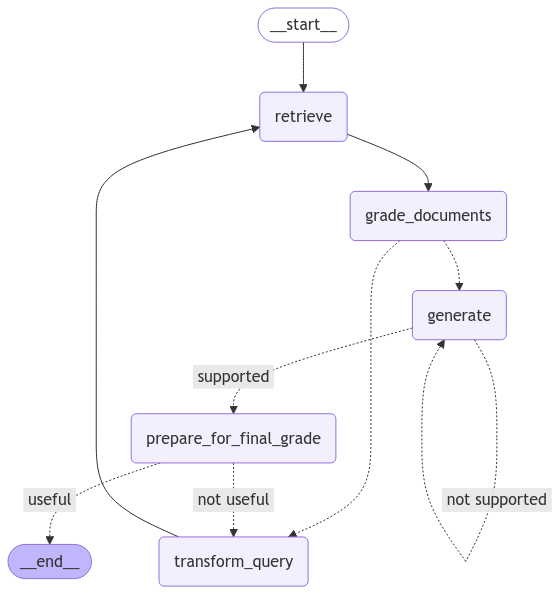

In [6]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# визуализируем полученный граф
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
inputs = {"keys": {"question": "Что лучшие Наруто или Блич"}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value['keys']['generation'])